# Machine Learning for Sepsis Pathway 

## Verification Notebook. 

Setup Libraries and plotting defaults. 

In [1]:
import sys
import os
import pickle

import pandas as pd
import numpy as np
import seaborn as sns
#import statsmodels.formula.api as smf
#from statsmodels.stats.anova import anova_lm


import re
import matplotlib.pyplot as plt
from openpyxl import load_workbook
from pandasql import sqldf
import sqlalchemy
import pyodbc

import dfply as dfp
from dfply import *

import datetime
from datetime import *

import pyodbc
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics         import balanced_accuracy_score, precision_score, classification_report
from sklearn.metrics         import recall_score, f1_score, make_scorer, cohen_kappa_score

from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import sklearn

from sklearn import model_selection
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import svm
from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier

import forestci as fci

from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, FunctionTransformer, PowerTransformer
from sklearn.metrics import r2_score, classification_report, confusion_matrix, roc_auc_score, accuracy_score, balanced_accuracy_score, precision_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
#from statsmodels.stats.outliers_influence import variance_inflation_factor
#from statsmodels.tools.tools import add_constant
import xgboost as xgb
from imblearn.over_sampling import SMOTENC
n_est=55

from hyperopt.pyll import scope
from hyperopt import fmin, tpe, hp, SparkTrials, Trials, STATUS_OK

pd.set_option('display.max_columns', None)


import Utilities
import importlib
importlib.reload(Utilities)

import MLUtilities
importlib.reload(MLUtilities)

from matplotlib.colors import to_rgba

plt.style.use('./CEIH.mplstyle')
color_dict = {0: to_rgba('#32C0D2', 1),
                1: to_rgba("#E0B165", 1),}

cmap_blended = sns.blend_palette(["#ADE6ED","#70D3E0","#32C0D2","#289AA8","#307078"], as_cmap=True)


import math
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1],idx-1
    else:
        return array[idx],idx
    

    
OtherValues = {'TriageCategory_2':'Triage Category 2', 'SoBFlag': 'Shortness of Breath', 'TriageCategory_4':'Triage Category 4',
               'TriageCategory_1':'Triage Category 1', 'TriageCategory_5':'Triage Category 5', 'TriageCategory_3':'Triage Category 3',
             'FirstGCSScoreAdult':'Glasgow Coma Scale',
               'FirstUrinalysisBlood': 'Urinalysis Blood', 'IndigenousStatusDescription_Not Aboriginal-TSI':  'Non Indiginous',
               'IndigenousStatusDescription_Not Stated':  'Indiginous Status not stated', 'FirstUrinalysisLeukocytes':'Urinalysis Leukocytes',
               'FirstPulseRateBPM':'Pulse Rate', 'FirstRespiration':'Respiration Rate', 'FirstSpO2':'O2 Saturation (%)',  'Gender_Male':'Sex - Male',
               'FirstLevelofConsciousness':'Level of Consciousness', 'IndigenousStatusDescription_Aboriginal and TSI':'Aboriginal and TSI',
               'IndigenousStatusDescription_TSI':'TSI','Gender_Indeterminate':'Sex - Indeterminate', 'Gender_Unknown':'Sex - Unknown',
               'FirstO2Flow':'O2 Flow ','GENDERCODE_Male':'Sex - Male','GENDERCODE_Unknown':'Sex - Unknown',
               'GENDERCODE_Indeterminate':'Sex - Indeterminate'
               }

plotSettings = {
        #  ( bins, xmin, xmax, log/linear)
        'AGEONADMISSION':(45,19.5,109.5,'linear','Age (y)', False, 0,0),
        
        
        'FirstBloodGlucose':(50,0,100,'log','Blood Glucose [mmol/L]', False,0, 0),
        'FirstTemperatureDegreesC':(50,30,45,'log', r"Temperature [$^\circ$C]", True,35.5,38.1),
                'FirstWeightKg':(50,50,150,'log','Weight [kg]', False, 0,0),

        
        'FirstPainAssessment': (11,-0.5,10.5,'log','Pain Assessment', False, 8,10),
        'FirstBPSystolic': (50,50,250,'log', 'BP Systolic [mm Hg]',True, 100,170 ),
        'FirstBPDiastolic': (50,0,200,'log', 'BP Diastolic [mm Hg]', False,0,0),
        'FirstEstimatedGlomerularFiltrationRate': (50,0,100,'log',r"Estimated Glomerular Filtration Rate [mL/min/1.73m$^{2}$]", True, 60, 100),
        'FirstCreatinine': (50,0,800,'log',r"Creatinine - Serum [$\mu$mol/L]", True, 45, 110),
        'FirstAlbumin': (60,0,60,'log','Albumin  Level [g/L]', True, 30, 48),
        'FirstTotalBilirubin': (60,0,100,'log',r"Total Bilirubin Level [$\mu$mol/L]", True, 2, 24 ),
        'FirstAlkalinePhosphatase': (60,0,800,'log','Alkaline Phosphatase Level [U/L]',True, 30,110),
        'FirstAlanineAminotransferase': (60,0,700,'log','Alanine Aminotransferase Level [U/L]', True,0,55),
        'FirstAspartateAminotransferase': (60,0,700,'log','Aspartate Aminotransferase Level [U/L]', True, 0,45),
        'FirstGammaGlutamylTransferase': (60,0,700,'log','Gamma Glutamyl Transferase Level [U/L]', True, 0, 60),
        'FirstLactateDehydrogenase': (60,0,1200,'log','Lactate Dehydrogenase [U/L]', True, 120, 250),
        'FirstHaemoglobin': (50,10, 220,'log','Haemoglobin [g/L]', True, 115, 175),
        'FirstWhiteCellCount': (50,0, 50,'log',r"White Cell Count [$\times 10^{9}$/L]",True, 4,11),
        'FirstPlateletCount': (50,0, 1000,'log',r"Platelet Count [$\times 10^{9}$/L]",True,150,500),
        'FirstNeutrophils': (50,0, 50,'log',r"Absolute Neutrophil Count [$\times 10^{9}$/L]",True,1.80,7.50),
        'FirstDDimer': (40,0, 20,'log',r"D-Dimer [mg/L]",True,0,0.79),
        'FirstCreactiveprotein': (50,0, 600,'log',r"C-Reactive Protein [mg/L]",True, 0,8),
        'FirstTroponinT': (50,0, 600,'log',r"Troponin T Level [mg/L]",True,0,16),
        'FirstNTproBNP': (50,0, 40000,'log',r"NT-pro Brain Natriuretic Peptide [mg/L]",True,0,124),
        
        'FirstAnionGapVenous': (50,0, 50,'log',r"Anion Gap Venous [mmol/L]", True, 7, 17),
        'FirstAnionGapArterial': (50,0, 50,'log',r"Anion Gap Arterial [mmol/L]",  True, 7, 17),
        'FirstBaseExcessVenous': (50,-30, 30,'log',r"Base Excess Venous [mmol/L]", True, -3, 3),
        'FirstBaseExcessArterial': (50,-30, 30,'log',r"Base Excess Arterial [mmol/L]", True, -3, 3),
        'FirstBilirubinVenous': (60,0, 60,'log',r"Bilirubin Venous [$\mu$mol/L]", True, 2,24),
        'FirstBilirubinArterial': (60,0, 60,'log',r"Bilirubin Arterial [$\mu$mol/L]", True, 2,24),
        'FirstCarboxyhaemoglobinVenous': (50,0, 20,'log',r"Carboxyhaemoglobin Venous [%]", True, 0.3, 1.8),
        'FirstCarboxyhaemoglobinArterial': (50,0, 20,'log',r"Carboxyhaemoglobin Arterial [%]", True, 0.3, 1.8),
        'FirstChlorideDirectVenous': (50,50, 150,'log',r"Chloride Direct Venous [mmol/L]",False, 100,109),
        'FirstChlorideDirectArterial': (50,50, 150,'log',r"Chloride Direct Arterial [mmol/L]", True, 100,109),
        'FirstCreatinineVenous':(50,0,500,'log',r"Creatinine Venous [$\mu$mol/L]", True, 50, 120),
        'FirstCreatinineArterial':(50,0,500,'log',r"Creatinine Arterial [$\mu$mol/L]", True, 50,120),
        'FirstGlucoseVenous':(50,0,30,'log',r"Glucose  Venous [mmol/L]", False,0,0),
        'FirstGlucoseArterial':(50,0,30,'log',r"Glucose  Arterial [mmol/L]", True,2.6,5.6),
        'FirstIonised Calcium Venous':(50,0,2,'log',r"Ionised Calcium Venous [mmol/L]", True, 1.1, 1.3),
        'FirstIonised Calcium Arterial':(50,0,2,'log',r"Ionised Calcium Arterial [mmol/L]", True, 1.1, 1.3),
        'FirstLactateVenous':(50,0,30,'log',r"Lactate Venous [mmol/L]", True, 0.2, 2.0),
        'FirstLactateArterial':(50,0,30,'log',r"Lactate Arterial [mmol/L]", True, 0.2, 2.0),
        'FirstMethaemoglobinVenous': (20,0, 3,'log',r"Methaemoglobin Venous [%]", True, 0.4, 1.2),
        'FirstMethaemoglobinArterial': (20,0, 3,'log',r"Methaemoglobin Arterial [%]", True, 0.2,0.6),
        'FirstOxygenSaturationVenous': (50,0, 100,'log',r"Oxygen Saturation Venous [%]", False, 0,0),
        'FirstOxygenSaturationArterial': (50,0, 100,'log',r"Oxygen Saturation Arterial [%]", True,95, 99),
        'FirstOxyhaemoglobinVenous': (50,0, 100,'log',r"Oxyhaemoglobin Venous [%]", False, 0,0),
        'FirstOxyhaemoglobinArterial': (50,0, 100,'log',r"Oxyhaemoglobin Arterial [%]", False, 0,0),
        'FirstReducedHaemoglobinVenous': (50,0, 100,'log',r"Reduced Haemoglobin Venous [%]", False, 0,0),
        'FirstReducedHaemoglobinArterial': (50,0, 100,'log',r"Reduced Haemoglobin Arterial [%]", False, 0,0),
        'FirstTotalHaemoglobinVenous': (50,10, 220,'log','Total Haemoglobin Venous [g/L]', True, 115,180),
        'FirstTotalHaemoglobinArterial': (50,10, 220,'log','Total Haemoglobin Arterial [g/L]', True, 115,180), 
        'FirstpCO2Venous': (50,0,150,'log', 'pCO2 Venous [mm Hg]', True,41,51),
        'FirstpCO2Arterial': (50,0,150,'log', 'pCO2 Arterial [mm Hg]', True, 35, 45 ),
        'FirstpO2Venous': (50,0,200,'log', 'pO2 Venous [mm Hg]', True, 25,40),
        'FirstpO2Arterial': (50,0,200,'log', 'pO2 Arterial [mm Hg]', True,67, 108),
        'FirstpHVenous': (50,6.8,7.8,'log', 'pH Venous', True, 7.32,7.42),
        'FirstpHArterial': (50,6.8,7.8,'log', 'pH Arterial', True, 7.36, 7.44),
        'FirstPotassiumDirectVenous':(50,0,10,'log',r"Potassium Direct Venous [mmol/L]", False, 0,0),
        'FirstPotassiumDirectArterial':(50,0,10,'log',r"Potassium Direct Arterial [mmol/L]", True, 3.1, 4.2),
        'FirstSodiumDirectVenous':(50,100,180,'log',r"Sodium Direct Venous [mmol/L]", False, 0,0),
        'FirstSodiumDirectArterial':(50,100,180,'log',r"Sodium Direct Arterial [mmol/L]", True, 137, 145),
        
        'FirstO2Flow':(20,0,20,'log',r"O$_{2}$ Flow", True,0,5),
        'FirstPulseRateBPM':(50,0,200,'log','Pulse Rate',True,60,100),
        'FirstSpO2':(50,0,100,'log',r"O$_{2}$ Saturation [%]",True,94,100),
         'FirstRespiration':(20,0,40,'log','Respiration Rate',True,10,21),
         'FirstLevelofConsciousness':(4,-0.5,3.5,'log',"Level of Consciousness",True,-0.5,2),
        'FirstGCSScoreAdult':(16,-0.5,15.5,'log','Glasgow Coma Scale',False,0,0)
        
        }


Failed to import duecredit due to No module named 'duecredit'
c:\Users\ibertr02\venvs\ceihml\Lib\site-packages\snowflake\connector\options.py:103: UserWarning: You have an incompatible version of 'pyarrow' installed (15.0.2), please install a version that adheres to: 'pyarrow<10.1.0,>=10.0.1; extra == "pandas"'
  warn_incompatible_dep(
Failed to import ArrowResult. No Apache Arrow result set format can be used. ImportError: DLL load failed while importing arrow_iterator: The specified procedure could not be found.


# Load Data Files 

In [2]:
# Sepsis HeartFailure PE Pneumonia COPD UTI
# SepsisPneumonia
Diagnosis =   "Sepsis"
# Diagnosis = 'SepsisPneumonia'
# Diagnosis = 'Admission'
# Diagnosis = 'GenMed'

DiagnosisString=Diagnosis+'Flag'


# DataSet = 'DataSet3a'

# MLModel = 'randomforest'

print(Diagnosis,DiagnosisString)

Sepsis SepsisFlag


In [3]:
start_date =  '2023-01-01'  #dates[Facility][0]
end_date   =  '2024-08-01' #dates[Facility][1]

select_start_date = '2023-01-01'

DataSet = 'DataSet5'

DataReasons = "Verification"
# clinics=Utilities.clinics(Facilit

Data_Storage_File = 'DataFiles\Emergency_Country_IPInfo_Complete_Numeric_Numeric_{}_{}_{}_Stage_01.pkl'.format(start_date,end_date,DataReasons)
print(Data_Storage_File)


with open(Data_Storage_File, 'rb') as file:
    Emergency_IPInfo_Complete_Numeric = pd.read_pickle(file)
    


DataFiles\Emergency_Country_IPInfo_Complete_Numeric_Numeric_2023-01-01_2024-08-01_Verification_Stage_01.pkl


In [5]:
Emergency_IPInfo_Complete_Numeric = Emergency_IPInfo_Complete_Numeric.loc[:,~Emergency_IPInfo_Complete_Numeric.columns.duplicated()] # remove duplicate columns because I am a doofus


Emergency_IPInfo_Complete_Numeric = Emergency_IPInfo_Complete_Numeric.loc[Emergency_IPInfo_Complete_Numeric.AGEONADMISSION>17].copy()

Emergency_IPInfo_Complete_Numeric.loc[Emergency_IPInfo_Complete_Numeric.AGEONADMISSION.between(0,17),'age_range']='0-17'
Emergency_IPInfo_Complete_Numeric.loc[Emergency_IPInfo_Complete_Numeric.AGEONADMISSION.between(18,33),'age_range']='18-33'
Emergency_IPInfo_Complete_Numeric.loc[Emergency_IPInfo_Complete_Numeric.AGEONADMISSION.between(34,48),'age_range']='34-48'
Emergency_IPInfo_Complete_Numeric.loc[Emergency_IPInfo_Complete_Numeric.AGEONADMISSION.between(49,64),'age_range']='49-64'
Emergency_IPInfo_Complete_Numeric.loc[Emergency_IPInfo_Complete_Numeric.AGEONADMISSION.between(65,78),'age_range']='65-78'
Emergency_IPInfo_Complete_Numeric.loc[Emergency_IPInfo_Complete_Numeric.AGEONADMISSION.between(79,98),'age_range']='79-98'
Emergency_IPInfo_Complete_Numeric.loc[Emergency_IPInfo_Complete_Numeric.AGEONADMISSION.between(98,120),'age_range']='98+'
Emergency_IPInfo_Complete_Numeric.loc[Emergency_IPInfo_Complete_Numeric.AGEONADMISSION.between(121,200),'age_range']='Unknown'

Emergency_IPInfo_Complete_Numeric['IndiginousFlag'] = 0  # np.where((Emergency_IPInfo_Complete_Numeric.IndiginousStatus.isna()|Emergency_IPInfo_Complete_Numeric.IndiginousStatus=='Not Aboriginal-TSI'),0,1)
Emergency_IPInfo_Complete_Numeric.loc[Emergency_IPInfo_Complete_Numeric.IndiginousStatus.isin(['Aboriginal','Aboriginal and TSI', 'TSI']),'IndiginousFlag'] = 1


# DiagnosisString='SepsisFlag'

if Diagnosis == "SepsisPneumonia":
    Emergency_IPInfo_Complete_Numeric[DiagnosisString] = 0
    Emergency_IPInfo_Complete_Numeric.loc[(Emergency_IPInfo_Complete_Numeric.SepsisFlag==1)|(Emergency_IPInfo_Complete_Numeric.PneumoniaFlag==1), DiagnosisString] = 1

if Diagnosis == 'Admission':
    Emergency_IPInfo_Complete_Numeric[DiagnosisString] = 0
    Emergency_IPInfo_Complete_Numeric.loc[(Emergency_IPInfo_Complete_Numeric['InitialIPLoS']>24), DiagnosisString] = 1
    
    if DataSet == 'DataSet5':
        Emergency_IPInfo_Complete_Numeric[DiagnosisString] = 0
        Emergency_IPInfo_Complete_Numeric.loc[ (Emergency_IPInfo_Complete_Numeric['InitialIPLoS']>6), DiagnosisString] = 1


if Diagnosis == 'GenMed':
    Emergency_IPInfo_Complete_Numeric[DiagnosisString] = 0
    for g in GenMedList:
        Emergency_IPInfo_Complete_Numeric.loc[(Emergency_IPInfo_Complete_Numeric.GROUPCODE.str.contains(g))  & (Emergency_IPInfo_Complete_Numeric['InitialIPLoS']>6), DiagnosisString] = 1
   


In [6]:
Data_Storage_File = 'DataFiles\Indigenous_EDI_list.pkl'   #.format(start_date,end_date,DataReasons)
print(Data_Storage_File)

with open(Data_Storage_File, 'rb') as file:
    indiginous_client_list = pd.read_pickle(file)

DataFiles\Indigenous_EDI_list.pkl


In [7]:
Emergency_IPInfo_Complete_Numeric['IndigenousEDIFlag'] = 0  # np.where((Emergency_IPInfo_Complete_Numeric.IndiginousStatus.isna()|Emergency_IPInfo_Complete_Numeric.IndiginousStatus=='Not Aboriginal-TSI'),0,1)
Emergency_IPInfo_Complete_Numeric.loc[Emergency_IPInfo_Complete_Numeric.CLIENTGUID.isin(indiginous_client_list),'IndigenousEDIFlag'] = 1

# Settings for Machine Learning Model 

In [ ]:
# # Sepsis HeartFailure PE Pneumonia COPD UTI
# # SepsisPneumonia
# Diagnosis =   "Sepsis"
# # Diagnosis = 'SepsisPneumonia'
# # Diagnosis = 'Admission'
# # Diagnosis = 'GenMed'

# DiagnosisString=Diagnosis+'Flag'

# PlotString = 'Sepsis Pathway'


# # PlotString = 'Admitted'

# # DataSet1 All observations 
# # DataSet2 Not including Oxygen Flow 
# # Dataset3  Dataset2 plus age and gender
# #  Dataset4 3 plus restriction on TC to 3 4 and 5 
# #  Dataset 3 with LoS > 6 hours. 



# DataSet = 'DataSet3'

In [8]:


GenMedList = ['LMH-LGMED','LMH-LAMU',
              "MPH-MGMED", 
              "FMC-GENMED",
              "NHS-GENMED",
              "RAH-GENMED",
              "QEH-GENMED", 'QEH-GM-AMU'
              ]
# DiagnosisString='SepsisFlag'

if Diagnosis == "SepsisPneumonia":
    Emergency_IPInfo_Complete_Numeric[DiagnosisString] = 0
    Emergency_IPInfo_Complete_Numeric.loc[(Emergency_IPInfo_Complete_Numeric.SepsisFlag==1)|(Emergency_IPInfo_Complete_Numeric.PneumoniaFlag==1), DiagnosisString] = 1

if Diagnosis == 'Admission':
    Emergency_IPInfo_Complete_Numeric[DiagnosisString] = 0
    Emergency_IPInfo_Complete_Numeric.loc[(Emergency_IPInfo_Complete_Numeric['LOSHOUR']>24), DiagnosisString] = 1
    
    if DataSet == 'DataSet5':
        Emergency_IPInfo_Complete_Numeric[DiagnosisString] = 0
        Emergency_IPInfo_Complete_Numeric.loc[(Emergency_IPInfo_Complete_Numeric['LOSHOUR']>6), DiagnosisString] = 1


if Diagnosis == 'GenMed':
    Emergency_IPInfo_Complete_Numeric[DiagnosisString] = 0
    for g in GenMedList:
        Emergency_IPInfo_Complete_Numeric.loc[(Emergency_IPInfo_Complete_Numeric.GROUPCODE.str.contains(g))  & (Emergency_IPInfo_Complete_Numeric['InitialIPLoS']>6), DiagnosisString] = 1
   


print("Diagnosis being investigated = {}".format(DiagnosisString))
print("Total Number of Cases = {}".format(len(Emergency_IPInfo_Complete_Numeric.index)))
print("Number of {} Cases ".format(DiagnosisString),len(Emergency_IPInfo_Complete_Numeric[Emergency_IPInfo_Complete_Numeric[DiagnosisString]==1]))


Diagnosis being investigated = SepsisFlag
Total Number of Cases = 119321
Number of SepsisFlag Cases  542


In [9]:
print("Diagnosis being investigated = {}".format(DiagnosisString))
print("Total Number of Indiginous Cases = {}".format(len(Emergency_IPInfo_Complete_Numeric.loc[Emergency_IPInfo_Complete_Numeric.IndiginousFlag==1].index)))
print("Number of {} Cases ".format(DiagnosisString),len(Emergency_IPInfo_Complete_Numeric[(Emergency_IPInfo_Complete_Numeric[DiagnosisString]==1) & (Emergency_IPInfo_Complete_Numeric.IndiginousFlag==1)]))


Diagnosis being investigated = SepsisFlag
Total Number of Indiginous Cases = 9205
Number of SepsisFlag Cases  37


In [10]:
# IndigenousEDIFlag
print("Diagnosis being investigated = {}".format(DiagnosisString))
print("Total Number of EDI Indigenous Cases = {}".format(len(Emergency_IPInfo_Complete_Numeric.loc[Emergency_IPInfo_Complete_Numeric.IndigenousEDIFlag==1].index)))
print("Number of {} Cases ".format(DiagnosisString),len(Emergency_IPInfo_Complete_Numeric[(Emergency_IPInfo_Complete_Numeric[DiagnosisString]==1) & (Emergency_IPInfo_Complete_Numeric.IndigenousEDIFlag==1)]))

Diagnosis being investigated = SepsisFlag
Total Number of EDI Indigenous Cases = 6920
Number of SepsisFlag Cases  38


In [84]:
DataSet = 'DataSet22_b'

AnalysisVariable =['FirstBPSystolic', 'FirstLevelofConsciousness',
    'FirstPulseRateBPM', 'FirstRespiration', 'FirstSpO2',
    'FirstTemperatureDegreesC', DiagnosisString]

if '1_' in DataSet:
    AnalysisVariable.append('FirstO2Flow')
elif '01' in DataSet:
    AnalysisVariable.append('FirstO2Flow')
elif '11' in DataSet:
    AnalysisVariable.append('FirstO2Flow')
elif '21' in DataSet:
    AnalysisVariable.append('FirstO2Flow')
if ('DataSet1' in DataSet):
    AnalysisVariable.append('GENDERCODE')
if ('DataSet2' in DataSet):
    AnalysisVariable.append('GENDERCODE')
    AnalysisVariable.append('AGEONADMISSION')

    

    
df = Emergency_IPInfo_Complete_Numeric.copy() 
  
if '_a' in DataSet:
    print("check")
    df = df.loc[df.AGEONADMISSION>64].copy()
elif '_b' in DataSet:
    df = df.loc[df.AGEONADMISSION<65].copy()

 
    
df.name='{} diagnosis detected from full Diagnosis list, updated'.format(Diagnosis)
importlib.reload(MLUtilities)
df = MLUtilities.setDefaults(df)

print("\n{}".format(DataSet))

print("\n{}".format(DataSet))
print("Diagnosis being investigated = {}".format(DiagnosisString))
print("Total Number of Cases = {}".format(len(df.index)))
print("Number of {} Cases ".format(DiagnosisString),len(df[df[DiagnosisString]==1]))
print(AnalysisVariable)


Data_Storage_File = 'Results/Nov_2024_{}_{}_BestFit_Models_Pathway_ED.pkl'.format(DiagnosisString,DataSet)
print(Data_Storage_File)

with open(Data_Storage_File, 'rb') as file:
    ObjectsToSave = pd.read_pickle(file)
    
best_model_RandomForest, best_model_XGBoost, all_cols, X_valid, y_valid ,trials_rf_df,trials_XGB_df= ObjectsToSave


# df = df.loc[:,~df.columns.duplicated()] # remove duplicate columns because I am a doofus

df['FirstLactateBG'] = np.where(df['FirstLactateArterialDtm'] < df ['FirstLactateVenousDtm'], df['FirstLactateArterial'], df['FirstLactateVenous'])
df['FirstBaseExcessBG'] = np.where(df['FirstBaseExcessArterialDtm'] < df ['FirstBaseExcessVenousDtm'], df['FirstBaseExcessArterial'], df['FirstBaseExcessVenous'])

df['PrimaryDiagnosisCode'] = df['DIAGNOSIS_LIST'].str.split(' ').str[0]




      

# importlib.reload(MLUtilities)
# df = MLUtilities.setDefaultsLactate(df)

df_verification = df[AnalysisVariable].copy()
df_verification[DiagnosisString] = df_verification[DiagnosisString].astype('int')

# df_verification[DiagnosisString] = df_verification[DiagnosisString].astype('category')
# df_verification['TriageCategory'] = df_verification['TriageCategory'].astype('category')
# df_verification.dropna(inplace=True)


df_verification['FirstO2Flow'] = df['FirstO2Flow'] 

df_verification['FirstLactateBG'] = df['FirstLactateBG'] 
df_verification['FirstBaseExcessBG'] =   df['FirstBaseExcessBG']
df_verification['FirstGCSScoreAdult'] = df['FirstGCSScoreAdult']


Emergency_IPInfo_Complete_Numeric[DiagnosisString] = Emergency_IPInfo_Complete_Numeric[DiagnosisString].astype('int')


print(df_verification.columns)

df_verification['FirstBPSystolicRed'] = np.where(df_verification['FirstBPSystolic'] <=99, 1, np.where(df_verification['FirstBPSystolic'] >=180, 1, 0))
df_verification['FirstRespirationRed'] = np.where(df_verification['FirstRespiration'] <=7, 1, np.where(df_verification['FirstRespiration'] >=26, 1, 0))
df_verification['FirstSpO2Red'] = np.where(df_verification['FirstSpO2'] <=91, 1,  0)
df_verification['FirstO2FlowRed'] = np.where(df_verification['FirstO2Flow'] >=7, 1,  0)
df_verification['FirstPulseRateBPMRed'] = np.where(df_verification['FirstPulseRateBPM'] <=49, 1, np.where(df_verification['FirstPulseRateBPM'] >=120, 1, 0))
df_verification['FirstTemperatureDegreesCRed'] = np.where(df_verification['FirstTemperatureDegreesC'] <=35, 1, np.where(df_verification['FirstTemperatureDegreesC'] >=38.6, 1, 0))
df_verification['FirstLevelofConsciousnessRed'] = np.where(df_verification['FirstLevelofConsciousness'] >=2, 1,  0)
df_verification['FirstLactateBGRed'] = np.where(df_verification['FirstLactateBG'] >=2, 1,  0)

df_verification['FirstBPSystolicPurple'] = np.where(df_verification['FirstBPSystolic'] <=99, 1, np.where(df_verification['FirstBPSystolic'] >=200, 1, 0))
df_verification['FirstRespirationPurple'] = np.where(df_verification['FirstRespiration'] <=7, 1, np.where(df_verification['FirstRespiration'] >=31, 1, 0))
df_verification['FirstSpO2Purple'] = np.where(df_verification['FirstSpO2'] <=88, 1,  0)
df_verification['FirstO2FlowPurple'] = np.where(df_verification['FirstO2Flow'] >=8, 1,  0)
df_verification['FirstPulseRateBPMPurple'] = np.where(df_verification['FirstPulseRateBPM'] <=39, 1, np.where(df_verification['FirstPulseRateBPM'] >=140, 1, 0))
df_verification['FirstLevelofConsciousnessPurple'] = np.where(df_verification['FirstLevelofConsciousness'] >=3, 1,  0)
df_verification['FirstLactateBGPurple'] = np.where(df_verification['FirstLactateBG'] >=4, 1,  0)

df_verification['FirstRespirationqSOFA'] = np.where(df_verification['FirstRespiration'] >=22, 1, 0)

df_verification['FirstRespirationqSOFA'] = np.where(df_verification['FirstRespiration'] >=22, 1, 0)
df_verification['FirstBPSystolicqSOFA'] = np.where(df_verification['FirstBPSystolic'] <=100, 1, 0)
df_verification['FirstGCSScoreAdultqSOFA'] = np.where(df_verification['FirstGCSScoreAdult'] <15, 1, 0)

RedVariables = []
for c in df_verification.columns:
    if ('First' in c) & ('Red' in c): RedVariables.append(c)
        
PurpleVariables = []
for c in df_verification.columns:
    if ('First' in c) & ('Purple' in c): PurpleVariables.append(c)
    
    
qSOFAVariables = []
for c in df_verification.columns:
    if ('First' in c) & ('qSOFA' in c): qSOFAVariables.append(c)
    
df_verification['RedNumber'] = df_verification[RedVariables].sum(axis=1)
df_verification['PurpleNumber'] = df_verification[PurpleVariables].sum(axis=1)
df_verification['qSOFANumber'] = df_verification[qSOFAVariables].sum(axis=1)

y_preds_Purple = np.where(df_verification.PurpleNumber>0,1,0)
y_preds_Red = np.where(df_verification.RedNumber>1,1,0)
y_preds_qSOFA = np.where(df_verification.qSOFANumber>1,1,0)

df_verification['PurpleFlag'] = np.where(df_verification.PurpleNumber>0,True,False)
df_verification['RedFlag'] = np.where(df_verification.RedNumber>1,True,False)
df_verification['qSOFAFlag'] = np.where(df_verification.qSOFANumber>1,True,False)

X_verification = df_verification[AnalysisVariable].drop(DiagnosisString, axis=1).copy()
x_vars = X.columns

y_verification = df_verification[[DiagnosisString]]
y_verification.value_counts()


DataSet22_b

DataSet22_b
Diagnosis being investigated = SepsisFlag
Total Number of Cases = 76845
Number of SepsisFlag Cases  136
['FirstBPSystolic', 'FirstLevelofConsciousness', 'FirstPulseRateBPM', 'FirstRespiration', 'FirstSpO2', 'FirstTemperatureDegreesC', 'SepsisFlag', 'GENDERCODE', 'AGEONADMISSION']
Results/Nov_2024_SepsisFlag_DataSet22_b_BestFit_Models_Pathway_ED.pkl
Index(['FirstBPSystolic', 'FirstLevelofConsciousness', 'FirstPulseRateBPM',
       'FirstRespiration', 'FirstSpO2', 'FirstTemperatureDegreesC',
       'SepsisFlag', 'GENDERCODE', 'AGEONADMISSION', 'FirstO2Flow',
       'FirstLactateBG', 'FirstBaseExcessBG', 'FirstGCSScoreAdult'],
      dtype='object')


SepsisFlag
0             76709
1               136
Name: count, dtype: int64

In [85]:
ModelChoice = 'XGB'

if ModelChoice == 'RF':
    best_model = best_model_RandomForest
    tmpString = 'Random Forest'
elif ModelChoice == 'XGB':
    best_model = best_model_XGBoost
    tmpString = 'XG Boost'
    
y_preds=best_model.predict (X_valid)

y_preds_proba=best_model.predict_proba (X_valid)
yprobs = np.delete(y_preds_proba,[0],1)
yprobs2 = np.ravel(yprobs,order='c') 

y2=np.ravel(y_valid,order='c')

y_verification_preds=best_model.predict (X_verification)

y_verification_preds_proba=best_model.predict_proba (X_verification)
y_verification_probs = np.delete(y_verification_preds_proba,[0],1)
y_verification_probs2 = np.ravel(y_verification_probs,order='c') 

y_verification_2=np.ravel(y_verification,order='c')

dropIdx = Emergency_IPInfo_Complete_Numeric.index.difference(df_verification.index)

Emergency_IPInfo_Complete_Numeric_tmp = Emergency_IPInfo_Complete_Numeric.drop(dropIdx)

Emergency_IPInfo_Complete_Numeric_tmp['yprob'] = y_verification_probs

fpr, tpr, thresholds = roc_curve(y_valid, yprobs)
auc = roc_auc_score(y_valid, yprobs)


# import math
# def find_nearest(array,value):
#     idx = np.searchsorted(array, value, side="left")
#     if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
#         return array[idx-1],idx-1
#     else:
#         return array[idx],idx

# val,idx = find_nearest(tpr,0.85)
# print(tpr[idx],fpr[idx],thresholds[idx])
threshold = np.interp(0.85,tpr,thresholds)  
false_positive =  np.interp(0.85,tpr,fpr)      # fpr[idx]
print(false_positive,threshold)

Emergency_IPInfo_Complete_Numeric_tmp['MLFlag'] = 0
Emergency_IPInfo_Complete_Numeric_tmp.loc[Emergency_IPInfo_Complete_Numeric_tmp['yprob'] > threshold, 'MLFlag'] = 1

# Emergency_IPInfo_Complete_Numeric_tmp[Emergency_IPInfo_Complete_Numeric_tmp.age_range.isna()]

0.20215955143507466 0.43805913627147675


In [86]:
z_0 = 1.96 # 95% coverage 1 is 66%

totalPresentations = Emergency_IPInfo_Complete_Numeric_tmp[[DiagnosisString]].count().values[0]
totalSepsis    = Emergency_IPInfo_Complete_Numeric_tmp[[DiagnosisString]].sum().values[0]
totalNotSepsis = Emergency_IPInfo_Complete_Numeric_tmp[Emergency_IPInfo_Complete_Numeric_tmp[DiagnosisString]==0][[DiagnosisString]].count().values[0]
totalMLFlag  = Emergency_IPInfo_Complete_Numeric_tmp[['MLFlag']].sum().values[0]
totalTP   = Emergency_IPInfo_Complete_Numeric_tmp[Emergency_IPInfo_Complete_Numeric_tmp[DiagnosisString]==1][['MLFlag']].sum().values[0]
totalFP   = Emergency_IPInfo_Complete_Numeric_tmp[Emergency_IPInfo_Complete_Numeric_tmp[DiagnosisString]==0][['MLFlag']].sum().values[0]
TPRate = totalTP/totalSepsis
DeltaTPRate = (z_0/np.sqrt(totalSepsis))*np.sqrt(TPRate*(1-TPRate))
FPRate = totalFP/totalNotSepsis
DeltaFPRate = (z_0/np.sqrt(totalNotSepsis))*np.sqrt(FPRate*(1-FPRate))

SepsisRate = totalSepsis/totalPresentations
DeltaSepsisRate = z_0*np.sqrt(1/totalPresentations)*np.sqrt(SepsisRate*(1-SepsisRate))

print(totalPresentations,totalSepsis,totalNotSepsis,totalMLFlag,totalTP,totalFP,TPRate,FPRate)
print( DeltaTPRate,DeltaFPRate)
print( "Sepsis Rate = ({:.2f} \u00B1 {:.2f})%".format(100*SepsisRate,100*DeltaSepsisRate))
print( "True Positive Rate  = ({:.2f} \u00B1 {:.2f})%".format(100*TPRate,100*DeltaTPRate))
print( "False Positive Rate = ({:.2f} \u00B1 {:.2f})%".format(100*FPRate,100*DeltaFPRate))

76845 136 76709 13712 111 13601 0.8161764705882353 0.17730644383318775
0.065099732276555 0.0027028019170864757
Sepsis Rate = (0.18 ± 0.03)%
True Positive Rate  = (81.62 ± 6.51)%
False Positive Rate = (17.73 ± 0.27)%


In [87]:
# Indigenous 
groupBy =  'age_range' #'IndiginousFlag' #  'HOSIPTALPROXY' #'IndiginousFlag' # 'GENDERCODE' #    'IndigenousEDIFlag' #' 'IndiginousFlag' #   'GENDERCODE' #  'IndiginousFlag' #  





totalPresentations = Emergency_IPInfo_Complete_Numeric_tmp[[DiagnosisString,groupBy]].groupby(groupBy).count()
totalPresentations.rename(columns={DiagnosisString:"Presentations"},inplace=True)
totalSepsis    = Emergency_IPInfo_Complete_Numeric_tmp[[DiagnosisString,groupBy]].groupby(groupBy).sum()
totalSepsis.rename(columns={DiagnosisString:"Sepsis Cases"},inplace=True)
# SepsisRate = totalSepsis/totalPresentations
totalTP   = Emergency_IPInfo_Complete_Numeric_tmp[Emergency_IPInfo_Complete_Numeric_tmp[DiagnosisString]==1][['MLFlag',groupBy]].groupby(groupBy).sum()
totalTP.rename(columns={"MLFlag":"True Positives"},inplace=True)
# sepsisRate = (totalSepsis.astype(float)).divide(totalPresentations.astype(float))
totalFP   = Emergency_IPInfo_Complete_Numeric_tmp[Emergency_IPInfo_Complete_Numeric_tmp[DiagnosisString]==0][['MLFlag',groupBy]].groupby(groupBy).sum()
totalFP.rename(columns={"MLFlag":"False Positives"},inplace=True)


summary_df = pd.concat((totalPresentations,totalSepsis,totalTP,totalFP),axis=1)
summary_df["Sepsis Rate"] = (summary_df["Sepsis Cases"]/summary_df["Presentations"]).round(4)
summary_df["Delta Sepsis Rate"] =  (z_0*np.sqrt(1./summary_df["Presentations"])*np.sqrt(summary_df["Sepsis Rate"]*(1-summary_df["Sepsis Rate"]))).round(4)   #(summary_df["Sepsis Cases"]/summary_df["Presentations"]).round(4)
# summary_df["True Positives"] = (summary_df["Sepsis Cases"]/summary_df["Presentations"]).round(4)



summary_df["True Positive Rate"] = (summary_df["True Positives"]/summary_df["Sepsis Cases"]).round(4)
summary_df["Delta True Positive Rate"] = (z_0*np.sqrt(1./summary_df["Sepsis Cases"])*np.sqrt(summary_df["True Positive Rate"]*(1-summary_df["True Positive Rate"]))).round(4) 

summary_df["False Positive Rate"] = (summary_df["False Positives"]/(summary_df["Presentations"]-summary_df["Sepsis Cases"] )).round(4)
summary_df["Delta False Positive Rate"] = (z_0*np.sqrt(1./(summary_df["Presentations"]-summary_df["Sepsis Cases"] ))*np.sqrt(summary_df["False Positive Rate"]*(1-summary_df["False Positive Rate"]))).round(4) 
# (summary_df["False Positives"]/(summary_df["Presentations"]-summary_df["Sepsis Cases"] )).round(4)
# summary_df.index.name = "Indigenous"

summary_df = summary_df[['Presentations', 'Sepsis Cases', 'Sepsis Rate','Delta Sepsis Rate','True Positives','True Positive Rate','Delta True Positive Rate','False Positives','False Positive Rate',       'Delta False Positive Rate']]

summary_df 
# totalSepsis  #.dtypes
# totalPresentations.dtypes
# SepsisRate


,Presentations,Sepsis Cases,Sepsis Rate,Delta Sepsis Rate,True Positives,True Positive Rate,Delta True Positive Rate,False Positives,False Positive Rate,Delta False Positive Rate
age_range,,,,,,,,,,
18-33,30143,25,0.0008,0.0003,15,0.6000,0.1920,1769,0.0587,0.0027
34-48,22746,33,0.0015,0.0005,26,0.7879,0.1395,3782,0.1665,0.0048
49-64,23956,78,0.0033,0.0007,70,0.8974,0.0673,8050,0.3371,0.0060


True Positive Rate  = (81.62 ± 6.51)%
[Text(0, 0, '18-33'), Text(0, 1, '34-48'), Text(0, 2, '49-64')]
[Text(0, 0, '18-33'), Text(0, 1, '34-48'), Text(0, 2, '49-64')]


C:\Users\ibertr02\AppData\Local\Temp\ipykernel_31400\15674055.py:70: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].yaxis.set_ticklabels(['']*nticks)


Text(0.5, 15.733333333333293, 'False Positive Rate')

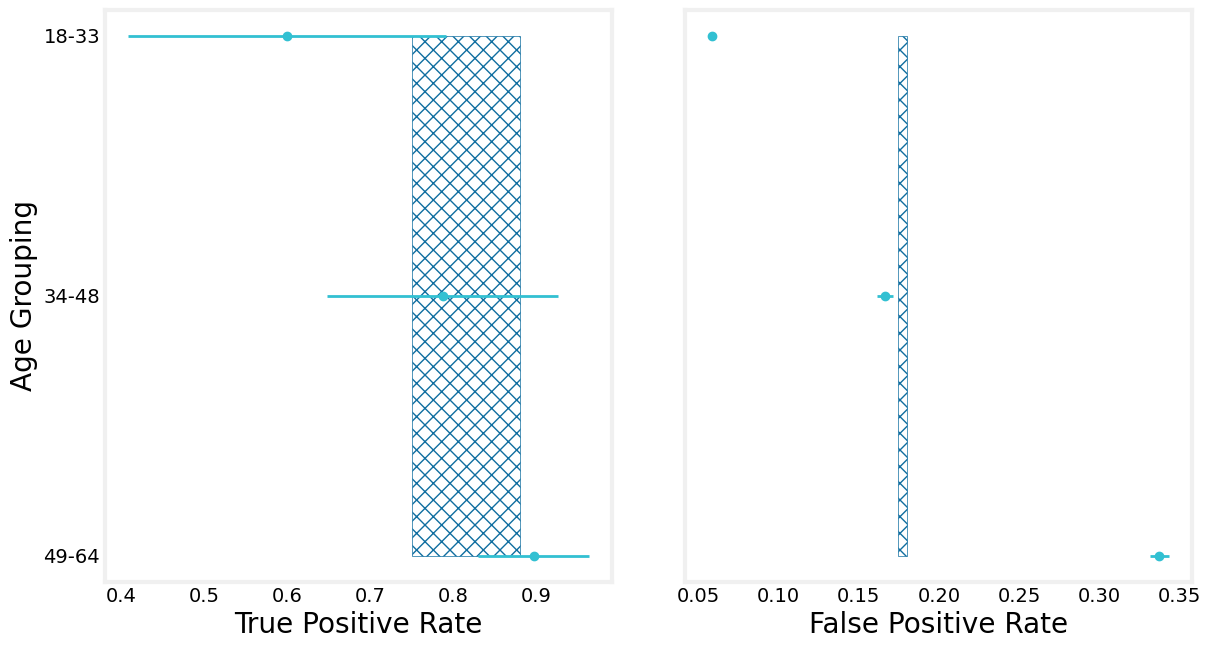

In [88]:
from matplotlib.ticker import MaxNLocator

if groupBy =='GENDERCODE':
    try:
        summary_df.drop(['Indeterminate', 'Unknown', ], inplace=True)
    except:
        pass

print( "True Positive Rate  = ({:.2f} \u00B1 {:.2f})%".format(100*TPRate,100*DeltaTPRate))
tmp_df = summary_df.reset_index()
sizeY = (len(tmp_df.index)-1)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(5.9*2, 8.6*0.75))
fig.tight_layout() 

tp = sns.scatterplot(data=tmp_df, x='True Positive Rate',y=groupBy , ax=axs[0])

axs[0].errorbar(tmp_df['True Positive Rate'], tmp_df[groupBy], xerr=tmp_df['Delta True Positive Rate'], fmt='o')
axs[0].grid(False)
x1 = TPRate-DeltaTPRate
x2 = TPRate+DeltaTPRate
# y = np.arange(0,axs[0].get_ylim()[1],0.01)
axs[0].add_patch(plt.Rectangle( (x1,0), 2*DeltaTPRate,sizeY,hatch='xx',fill=None,edgecolor= "#106EA0"))
if groupBy=='HOSIPTALPROXY':
    axs[0].set_ylabel('Hospital',fontsize='x-large')
if groupBy == 'IndiginousFlag':
    axs[0].set_ylabel('Indigenous',fontsize='x-large')
    axs[0].yaxis.set_ticks([0,1])
    axs[0].yaxis.set_ticklabels(['False','True'],fontsize='large')
    # tp.set_yticklabels( ['','False','True',''],)
if groupBy == 'GENDERCODE':
    axs[0].set_ylabel('Gender',fontsize='x-large')
    axs[0].yaxis.set_ticks([0,1])

    axs[0].yaxis.set_ticklabels(['Female','Male'],fontsize='large')
    # tp.set_yticklabels( ['','False','True',''],)
    
if groupBy == 'age_range':
    axs[0].set_ylabel('Age Grouping',fontsize='x-large')
    axs[0].tick_params(axis='y', labelsize=14)

axs[0].set_xlabel('True Positive Rate',fontsize='x-large')

    
print(tp.get_yticklabels())  
fp = sns.scatterplot(data=tmp_df, x='False Positive Rate',y=groupBy , ax=axs[1])
# fp.set(xlim=(0.10,0.30))
print(fp.get_yticklabels())

axs[1].errorbar(tmp_df['False Positive Rate'], tmp_df[groupBy], xerr=tmp_df['Delta False Positive Rate'], fmt='o')
axs[1].grid(False)
x1 = FPRate-DeltaFPRate
x2 = FPRate+DeltaFPRate
# y = np.arange(0,axs[0].get_ylim()[1],0.01)
axs[1].add_patch(plt.Rectangle( (x1,0), 2*DeltaFPRate,sizeY,hatch='xx',fill=None,edgecolor= "#106EA0"))
# if groupBy=='HOSIPTALPROXY':
axs[1].set(ylabel='')
if groupBy == 'IndiginousFlag':
    # ax = plt.figure().gca()
    # axs[1].yaxis.set_major_locator(MaxNLocator(integer=True))
    axs[1].yaxis.set_ticks([0,1])
    axs[1].yaxis.set_ticklabels(['',''],fontsize='large')
if groupBy == 'GENDERCODE':
    axs[1].yaxis.set_ticks([0,1])
    axs[1].yaxis.set_ticklabels(['',''],fontsize='large')
    # tp.set_yticklabels( ['','False','True',''],)
if groupBy == 'age_range':
    # axs[0].set_ylabel('Age Grouping',fontsize='x-large')
    # axs[1].get_xticklabels()
    nticks = (len(axs[1].get_yticklabels()))
    axs[1].yaxis.set_ticklabels(['']*nticks)
axs[1].set_xlabel('False Positive Rate',fontsize='x-large')




In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf 

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(5.9*2, 8.6*0.75))

# f.tight_layout() 

item = 'MLFlag'
tmp_df = Emergency_IPInfo_Complete_Numeric[Emergency_IPInfo_Complete_Numeric[DiagnosisString]==1].copy() # summary_PD_First_df.loc[~summary_PD_First_df[item].isna()].copy()

tukey = pairwise_tukeyhsd(endog=tmp_df[item],     # Data
                          groups=tmp_df[groupBy],   # Groups
                          alpha=0.05)  

tukey.plot_simultaneous(xlabel='True Positive Rate',ax=axs[0])    # Plot group confidence intervals
axs[0].title.set_text('')
axs[0].grid(False)
print(tukey.summary())

item = 'MLFlag'
tmp2_df = Emergency_IPInfo_Complete_Numeric[Emergency_IPInfo_Complete_Numeric[DiagnosisString]==0].copy() # summary_PD_First_df.loc[~summary_PD_First_df[item].isna()].copy()

tukey = pairwise_tukeyhsd(endog=tmp2_df[item],     # Data
                          groups=tmp2_df[groupBy],   # Groups
                          alpha=0.05)  

tukey.plot_simultaneous(xlabel='False Positive Rate',ax=axs[1])    # Plot group confidence intervals
axs[1].title.set_text('')
axs[1].grid(False)


print(tukey.summary())

In [ ]:
# yprobs2 = np.ravel(yprobs,order='c') 

compareResults = pd.DataFrame({DiagnosisString:y_verification_2, "Prob":y_verification_probs2})
compareResults.describe()


ResultsFlag0 = compareResults.loc[compareResults[DiagnosisString]==0]
ResultsFlag1 = compareResults.loc[compareResults[DiagnosisString]==1]


yprobslog2 = np.log(yprobs2) 

compareResultsLog = pd.DataFrame({DiagnosisString:y2, "Prob":yprobslog2})
#print(compareResultsLog.describe())


ResultsFlag0_xgb_log = compareResultsLog.loc[compareResultsLog[DiagnosisString]==0]
ResultsFlag1_xgb_log = compareResultsLog.loc[compareResultsLog[DiagnosisString]==1]
fig, ax = plt.subplots(figsize=(7, 7))

if ModelChoice == 'RF':

    sns.histplot(data=ResultsFlag0, x="Prob",  binrange=[0.,1.], binwidth=0.025, stat = 'probability', color= "#E0B165", label='Not {}'.format(Diagnosis))
    sns.histplot(data=ResultsFlag1, x="Prob",  binrange=[0.,1.], binwidth=0.025,  stat = 'probability' , label='{}'.format(Diagnosis))
    plt.legend(loc=1, title="{}".format(tmpString))

    y = np.arange(0.,ax.get_ylim()[1],0.01)
    # print(len(y))
    x =  np.full(shape = len(y), fill_value = thresholds[idx])

    plt.plot(x,y,label='chance (auc=0.5)',color='k',linestyle='--')

    fig.patch.set_facecolor('white')
    plt.ylabel("Fraction")
    plt.xlabel("Score")
else: 
    sns.histplot(data=ResultsFlag0_xgb_log, x="Prob",  binrange=[-4,0.], binwidth=0.1, stat = 'probability',label='Not {}'.format(Diagnosis))
    sns.histplot(data=ResultsFlag1_xgb_log, x="Prob",  binrange=[-4,0.], binwidth=0.1,  stat = 'probability',  color= "#E0B165" , label='{}'.format(Diagnosis))
    plt.legend(loc=2,  title="XG Boost")
    plt.ylabel("Fraction")

    y = np.arange(0.,ax.get_ylim()[1],0.01)
    #print(len(y))
    x =  np.full(shape = len(y), fill_value = np.log(thresholds[idx]))

    plt.plot(x,y,label='chance (auc=0.5)',color='k',linestyle='--')
    plt.ylabel("Fraction")
    plt.xlabel("ln(Score)")
plt.savefig("Figures/Verfification_{}_{}_Score_Plot.png".format(DiagnosisString,tmpString), dpi=300, bbox_inches = "tight")



y_verification_preds2 = np.where(y_verification_probs2<thresholds[idx],0,1)

# fig, ax = plt.subplots(figsize=(7, 7))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_verification_2, y_verification_preds2, normalize='true')
    )
fig, ax = plt.subplots(figsize=(7,7))
cmp.plot(cmap=cmap_blended, ax=ax, text_kw={'fontsize':'x-large'})
ax.grid(False)

plt.savefig("Figures/Verification_{}_{}_Confusion_Matrix_Plot.png".format(DiagnosisString,tmpString), dpi=300, bbox_inches = "tight")

plt.show()




best_model[1].feature_importances_
feat_importances=pd.Series(best_model[1].feature_importances_ , index=all_cols)
feat_importances=pd.DataFrame(feat_importances).reset_index()

feat_importances.columns=['feature', 'feature_importance']



feat_importances.sort_values('feature_importance', ascending=False, inplace=True)

feat_importances['name'] = None
idx = feat_importances.index




for i in idx:
    # print(i)

    val = feat_importances.loc[i].feature
    # print(i,val)
    try:
        tmpValue = plotSettings[val][4]
        end = tmpValue.rfind(' [')
        # print(end)
        if (end > 0): 
            feat_importances.at[i,'name']= tmpValue[0:tmpValue.rfind(' [')]
        else:
            feat_importances.at[i,'name']= tmpValue
    except: 
        for item9 in OtherValues.keys():
            if val == item9:
                feat_importances.at[i,'name'] = OtherValues[item9]
        
        # if val == 'TriageCategory_2':
        #     feat_importances.at[i,'name']= 'Triage Category 2'
        # else:
        #     print(val)
# print(feat_importances)



In [ ]:
print(len(X_verification.index))
indiginous_idx = Emergency_IPInfo_Complete_Numeric.loc[Emergency_IPInfo_Complete_Numeric.IndiginousFlag==1].index

X_valid_idx = X_verification.index
index_choice = indiginous_idx.intersection(X_valid_idx)
X_indiginous_verification = X_verification.loc[index_choice].copy()
print(len(X_indiginous_verification))
print(100.*len(X_indiginous_verification)/len(X_verification.index))

In [ ]:
fpr, tpr, thresholds = roc_curve(y_valid, yprobs)
auc = roc_auc_score(y_valid, yprobs)
# plt.plot(fpr,tpr,label="Sepsis (RF, unoptimised), area="+str('{:.3f}'.format(auc)))


# x = np.arange(0,1,0.01)
# plt.plot(x,x,label='chance (auc=0.5)',color='k',linestyle='--')

# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.legend(loc=4)

# plt.show()

import math
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1],idx-1
    else:
        return array[idx],idx

val,idx = find_nearest(tpr,0.85)
print(tpr[idx],fpr[idx],thresholds[idx])
y_verification_preds=best_model.predict (X_indiginous_verification)

y_verification_preds_proba=best_model.predict_proba (X_indiginous_verification)
y_verification_probs = np.delete(y_verification_preds_proba,[0],1)
y_verification_probs2 = np.ravel(y_verification_probs,order='c') 

y_verification_2=np.ravel(y_verification.loc[index_choice],order='c')

# yprobs2 = np.ravel(yprobs,order='c') 

compareResults = pd.DataFrame({DiagnosisString:y_verification_2, "Prob":y_verification_probs2})
compareResults.describe()


ResultsFlag0 = compareResults.loc[compareResults[DiagnosisString]==0]
ResultsFlag1 = compareResults.loc[compareResults[DiagnosisString]==1]


yprobslog2 = np.log(yprobs2) 

compareResultsLog = pd.DataFrame({DiagnosisString:y2, "Prob":yprobslog2})
#print(compareResultsLog.describe())


ResultsFlag0_xgb_log = compareResultsLog.loc[compareResultsLog[DiagnosisString]==0]
ResultsFlag1_xgb_log = compareResultsLog.loc[compareResultsLog[DiagnosisString]==1]
fig, ax = plt.subplots(figsize=(7, 7))

if ModelChoice == 'RF':

    sns.histplot(data=ResultsFlag0, x="Prob",  binrange=[0.,1.], binwidth=0.025, stat = 'probability', color= "#E0B165", label='Not {}'.format(Diagnosis))
    sns.histplot(data=ResultsFlag1, x="Prob",  binrange=[0.,1.], binwidth=0.025,  stat = 'probability' , label='{}'.format(Diagnosis))
    plt.legend(loc=1, title="{}".format(tmpString))

    y = np.arange(0.,ax.get_ylim()[1],0.01)
    # print(len(y))
    x =  np.full(shape = len(y), fill_value = thresholds[idx])

    plt.plot(x,y,label='chance (auc=0.5)',color='k',linestyle='--')

    fig.patch.set_facecolor('white')
    plt.ylabel("Fraction")
    plt.xlabel("Score")
else: 
    sns.histplot(data=ResultsFlag0_xgb_log, x="Prob",  binrange=[-4,0.], binwidth=0.1, stat = 'probability',label='Not {}'.format(Diagnosis))
    sns.histplot(data=ResultsFlag1_xgb_log, x="Prob",  binrange=[-4,0.], binwidth=0.1,  stat = 'probability',  color= "#E0B165" , label='{}'.format(Diagnosis))
    plt.legend(loc=2,  title="XG Boost")
    plt.ylabel("Fraction")

    y = np.arange(0.,ax.get_ylim()[1],0.01)
    #print(len(y))
    x =  np.full(shape = len(y), fill_value = np.log(thresholds[idx]))

    plt.plot(x,y,label='chance (auc=0.5)',color='k',linestyle='--')
    plt.ylabel("Fraction")
    plt.xlabel("ln(Score)")
plt.savefig("Figures/Verfification_{}_{}_Score_Plot.png".format(DiagnosisString,tmpString), dpi=300, bbox_inches = "tight")



y_verification_preds2 = np.where(y_verification_probs2<thresholds[idx],0,1)

# fig, ax = plt.subplots(figsize=(7, 7))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_verification_2, y_verification_preds2, normalize='true')
    )
fig, ax = plt.subplots(figsize=(7,7))
cmp.plot(cmap=cmap_blended, ax=ax, text_kw={'fontsize':'x-large'})
ax.grid(False)

plt.savefig("Figures/Verification_{}_{}_Confusion_Matrix_Plot.png".format(DiagnosisString,tmpString), dpi=300, bbox_inches = "tight")

plt.show()



In [ ]:
Emergency_IPInfo_Complete_Numeric[['MLFlag',DiagnosisString,'GENDERCODE','IndiginousFlag','HOSIPTALPROXY']]  #.groupby('IndiginousFlag').sum()

## Gender

In [ ]:
X_verification.GENDERCODE.unique()

In [ ]:
print("Diagnosis being investigated = {}".format(DiagnosisString))
print("Total Number of female Cases = {}".format(len(Emergency_IPInfo_Complete_Numeric.loc[Emergency_IPInfo_Complete_Numeric.GENDERCODE=='Female'].index)))
print("Number of {} Cases ".format(DiagnosisString),len(Emergency_IPInfo_Complete_Numeric[(Emergency_IPInfo_Complete_Numeric[DiagnosisString]==1) & (Emergency_IPInfo_Complete_Numeric.GENDERCODE=='Female')]))


In [ ]:
print(len(X_verification.index))
female_idx = Emergency_IPInfo_Complete_Numeric.loc[Emergency_IPInfo_Complete_Numeric.GENDERCODE=='Female'].index

X_valid_idx = X_verification.index
index_choice = female_idx.intersection(X_valid_idx)
X_female_verification = X_verification.loc[index_choice].copy()
print(len(X_female_verification))
print(100.*len(X_female_verification)/len(X_verification.index))

In [ ]:
fpr, tpr, thresholds = roc_curve(y_valid, yprobs)
auc = roc_auc_score(y_valid, yprobs)
# plt.plot(fpr,tpr,label="Sepsis (RF, unoptimised), area="+str('{:.3f}'.format(auc)))


# x = np.arange(0,1,0.01)
# plt.plot(x,x,label='chance (auc=0.5)',color='k',linestyle='--')

# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.legend(loc=4)

# plt.show()

import math
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1],idx-1
    else:
        return array[idx],idx

val,idx = find_nearest(tpr,0.85)
print(tpr[idx],fpr[idx],thresholds[idx])
y_verification_preds=best_model.predict (X_female_verification)

y_verification_preds_proba=best_model.predict_proba (X_female_verification)
y_verification_probs = np.delete(y_verification_preds_proba,[0],1)
y_verification_probs2 = np.ravel(y_verification_probs,order='c') 

y_verification_2=np.ravel(y_verification.loc[index_choice],order='c')

# yprobs2 = np.ravel(yprobs,order='c') 

compareResults = pd.DataFrame({DiagnosisString:y_verification_2, "Prob":y_verification_probs2})
compareResults.describe()


ResultsFlag0 = compareResults.loc[compareResults[DiagnosisString]==0]
ResultsFlag1 = compareResults.loc[compareResults[DiagnosisString]==1]


yprobslog2 = np.log(yprobs2) 

compareResultsLog = pd.DataFrame({DiagnosisString:y2, "Prob":yprobslog2})
#print(compareResultsLog.describe())


ResultsFlag0_xgb_log = compareResultsLog.loc[compareResultsLog[DiagnosisString]==0]
ResultsFlag1_xgb_log = compareResultsLog.loc[compareResultsLog[DiagnosisString]==1]
fig, ax = plt.subplots(figsize=(7, 7))

if ModelChoice == 'RF':

    sns.histplot(data=ResultsFlag0, x="Prob",  binrange=[0.,1.], binwidth=0.025, stat = 'probability', color= "#E0B165", label='Not {}'.format(Diagnosis))
    sns.histplot(data=ResultsFlag1, x="Prob",  binrange=[0.,1.], binwidth=0.025,  stat = 'probability' , label='{}'.format(Diagnosis))
    plt.legend(loc=1, title="{}".format(tmpString))

    y = np.arange(0.,ax.get_ylim()[1],0.01)
    # print(len(y))
    x =  np.full(shape = len(y), fill_value = thresholds[idx])

    plt.plot(x,y,label='chance (auc=0.5)',color='k',linestyle='--')

    fig.patch.set_facecolor('white')
    plt.ylabel("Fraction")
    plt.xlabel("Score")
else: 
    sns.histplot(data=ResultsFlag0_xgb_log, x="Prob",  binrange=[-4,0.], binwidth=0.1, stat = 'probability',label='Not {}'.format(Diagnosis))
    sns.histplot(data=ResultsFlag1_xgb_log, x="Prob",  binrange=[-4,0.], binwidth=0.1,  stat = 'probability',  color= "#E0B165" , label='{}'.format(Diagnosis))
    plt.legend(loc=2,  title="XG Boost")
    plt.ylabel("Fraction")

    y = np.arange(0.,ax.get_ylim()[1],0.01)
    #print(len(y))
    x =  np.full(shape = len(y), fill_value = np.log(thresholds[idx]))

    plt.plot(x,y,label='chance (auc=0.5)',color='k',linestyle='--')
    plt.ylabel("Fraction")
    plt.xlabel("ln(Score)")
plt.savefig("Figures/Verfification_{}_{}_Score_Plot.png".format(DiagnosisString,tmpString), dpi=300, bbox_inches = "tight")



y_verification_preds2 = np.where(y_verification_probs2<thresholds[idx],0,1)

# fig, ax = plt.subplots(figsize=(7, 7))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_verification_2, y_verification_preds2, normalize='true')
    )
fig, ax = plt.subplots(figsize=(7,7))
cmp.plot(cmap=cmap_blended, ax=ax, text_kw={'fontsize':'x-large'})
ax.grid(False)

plt.savefig("Figures/Verification_{}_{}_Confusion_Matrix_Plot.png".format(DiagnosisString,tmpString), dpi=300, bbox_inches = "tight")

plt.show()



In [ ]:
accuracy  =accuracy_score(y_verification_2,y_verification_preds2)
balanced_accuracy = balanced_accuracy_score (y_verification_2,y_verification_preds2)
recall  =recall_score(y_verification_2,y_verification_preds2)
precision = precision_score(y_verification_2,y_verification_preds2)
f1 = f1_score(y_verification_2,y_verification_preds2)


print(" Accuracy = \t\t{:0.2f}".format(accuracy))
print(" Balanced Accuracy = \t{:0.2f}".format(balanced_accuracy))
print(" Recall = \t\t{:0.2f}".format(recall))
print(" Precsiion = \t\t{:0.2f}".format(precision))
print(" F1 = \t\t\t{:0.2f}".format(f1))

In [ ]:
print(feat_importances)

In [ ]:
from pandas.api.types import is_numeric_dtype

color_dict = {1: to_rgba("#32C0D2", 1),
                0: to_rgba("#E0B165",1),}

In [ ]:
n_features = len(feat_importances.index)
n_features = min(n_features,10)
print(n_features)
for i in range(n_features): 
    item = feat_importances.feature.values[i]
    # print(i,item,X_valid[item].dtype,is_numeric_dtype(X_valid[item]))
    if item in X_valid.keys():
        if is_numeric_dtype(X_valid[item]):
            fig, ax = plt.subplots(figsize=(7, 7))
            fig.tight_layout() 
            plotSettingValues = plotSettings[item]
            
            hist = sns.histplot(data=Emergency_IPInfo_Complete_Numeric.loc[~Emergency_IPInfo_Complete_Numeric[item].isna()], x=item,  stat= 'probability', bins=plotSettingValues[0], 
                label=plotSettingValues[4] , hue=DiagnosisString, palette={1: to_rgba("#32C0D2", 1), 0: to_rgba("#E0B165",1),}, #  color_dict,
                binrange=(plotSettingValues[1], plotSettingValues[2]), alpha=0.5, common_norm=False,)

            if plotSettingValues[5]:
                x1 = plotSettingValues[6]
                x2 = plotSettingValues[7]
                y = np.arange(0,ax.get_ylim()[1],0.01)
                ax.fill_betweenx(y,x1,x2, facecolor='none', edgecolor='black', hatch='xx',alpha=0.5, label='Normal Results')

            # print(hist.get_ylim())
            handles, labels  =  ax.get_legend_handles_labels()
            print(labels)
            if plotSettingValues[5]:
                ax.legend(handles, [ 'Normal Results', '{} Cases'.format(PlotString), 'Other Cases' ], loc='best',  title='Verification Sample\nED - Pathway',alignment='center')
            else: 
                ax.legend(handles, ['{} Cases'.format(PlotString), 'Other Cases' ],  loc='best',  title='Verification Sample\nED - Pathway',alignment='center')
            
            hist.plot()
            
            # print(ax.get_ylim())
            ax.set(xlabel=plotSettingValues[4])
            plt.yscale(plotSettingValues[3])

In [ ]:
# for i in range(n_features): 
item =  'FirstPainAssessment'  # feat_importances.feature.values[i]
# print(i,item,X_valid[item].dtype,is_numeric_dtype(X_valid[item]))
#if item in X_valid.keys():
# if is_numeric_dtype(X_valid[item]):
fig, ax = plt.subplots(figsize=(7, 7))
fig.tight_layout() 
plotSettingValues = plotSettings[item]

hist = sns.histplot(data=Emergency_IPInfo_Complete_Numeric.loc[~Emergency_IPInfo_Complete_Numeric[item].isna()], x=item,  stat= 'probability', bins=plotSettingValues[0], 
    label=plotSettingValues[4] , hue=DiagnosisString,palette={1: to_rgba("#32C0D2", 1), 0: to_rgba("#E0B165",1)}, #   color_dict,
    binrange=(plotSettingValues[1], plotSettingValues[2]), alpha=0.5,  common_norm=False,)

if plotSettingValues[5]:
    x1 = plotSettingValues[6]
    x2 = plotSettingValues[7]
    y = np.arange(0,ax.get_ylim()[1],0.01)
    ax.fill_betweenx(y,x1,x2, facecolor='none', edgecolor='black', hatch='xx',alpha=0.5, label='Normal Results')

# print(hist.get_ylim())
handles, labels  =  ax.get_legend_handles_labels()
print(labels)
if plotSettingValues[5]:
    ax.legend(handles, [ 'Normal Results', '{} Cases'.format(PlotString), 'Other Cases' ], loc='best',  title='Verification Sample\nED - Pathway',alignment='center')
else: 
    ax.legend(handles, ['{} Cases'.format(PlotString), 'Other Cases' ],  loc='best',  title='Verification Sample\nED - Pathway',alignment='center')

# print(ax.get_ylim())
ax.set(xlabel=plotSettingValues[4])
plt.yscale(plotSettingValues[3])

In [ ]:
f, ax = plt.subplots(figsize=(7, 7))
importlib.reload(Utilities)

#xlimits = (25,250)
#ylimits = (25,45)

#fig, ax = plt.subplots()
import matplotlib.patches as patches

#ax.set_xl

xkey = 'FirstBPSystolic'
ykey='FirstTemperatureDegreesC'

g = sns.scatterplot(data=Emergency_IPInfo_Complete_Numeric, x=xkey, y=ykey ,hue=DiagnosisString, alpha=.75, palette=color_dict)
print(plotSettings[xkey][1],plotSettings[xkey][2])
ax.set_xlim(plotSettings[xkey][1],plotSettings[xkey][2])
ax.set_ylim(plotSettings[ykey][1],plotSettings[ykey][2])

ax.set(xlabel=plotSettings[xkey][4],ylabel=plotSettings[ykey][4])

patchMin = (plotSettings[xkey][6],plotSettings[ykey][6])
patchWidth = plotSettings[xkey][7] - plotSettings[xkey][6]
patchHeight = plotSettings[ykey][7] - plotSettings[ykey][6]

rect = patches.Rectangle(patchMin, patchWidth, patchHeight, linewidth=2, edgecolor='black', facecolor='none',label='Normal Results')  #alpha=0.25)
ax.add_patch(rect)

handles, labels  =  ax.get_legend_handles_labels()
ax.legend(handles, ['Other Cases', 'Sepsis Cases',  'Normal Results'], 
          loc='best',  #bbox_to_anchor=(1,1), 
          title='Verification Sample\nED - Pathway',alignment='center')

In [ ]:
f, ax = plt.subplots(figsize=(7, 7))
importlib.reload(Utilities)

#xlimits = (25,250)
#ylimits = (25,45)

#fig, ax = plt.subplots()
import matplotlib.patches as patches

#ax.set_xl

xkey = 'FirstBPSystolic'
ykey='FirstTemperatureDegreesC'

g = sns.scatterplot(data=Emergency_IPInfo_Complete_Numeric[Emergency_IPInfo_Complete_Numeric.MLFlag==1], x=xkey, y=ykey ,hue=DiagnosisString, alpha=.75, palette=color_dict)
print(plotSettings[xkey][1],plotSettings[xkey][2])
ax.set_xlim(plotSettings[xkey][1],plotSettings[xkey][2])
ax.set_ylim(plotSettings[ykey][1],plotSettings[ykey][2])

ax.set(xlabel=plotSettings[xkey][4],ylabel=plotSettings[ykey][4])

patchMin = (plotSettings[xkey][6],plotSettings[ykey][6])
patchWidth = plotSettings[xkey][7] - plotSettings[xkey][6]
patchHeight = plotSettings[ykey][7] - plotSettings[ykey][6]

rect = patches.Rectangle(patchMin, patchWidth, patchHeight, linewidth=2, edgecolor='black', facecolor='none',label='Normal Results')  #alpha=0.25)
ax.add_patch(rect)

handles, labels  =  ax.get_legend_handles_labels()
ax.legend(handles, ['Other Cases', 'Sepsis Cases',  'Normal Results'], 
          loc='best',  #bbox_to_anchor=(1,1), 
          title='Verification - ML Positive',alignment='center')

In [ ]:
f, ax = plt.subplots(figsize=(7, 7))
importlib.reload(Utilities)

#xlimits = (25,250)
#ylimits = (25,45)

#fig, ax = plt.subplots()
import matplotlib.patches as patches

#ax.set_xl

xkey = 'FirstBPSystolic'
ykey='FirstTemperatureDegreesC'

g = sns.scatterplot(data=Emergency_IPInfo_Complete_Numeric[Emergency_IPInfo_Complete_Numeric.MLFlag==0], x=xkey, y=ykey ,hue=DiagnosisString, alpha=.75, palette=color_dict)
print(plotSettings[xkey][1],plotSettings[xkey][2])
ax.set_xlim(plotSettings[xkey][1],plotSettings[xkey][2])
ax.set_ylim(plotSettings[ykey][1],plotSettings[ykey][2])

ax.set(xlabel=plotSettings[xkey][4],ylabel=plotSettings[ykey][4])

patchMin = (plotSettings[xkey][6],plotSettings[ykey][6])
patchWidth = plotSettings[xkey][7] - plotSettings[xkey][6]
patchHeight = plotSettings[ykey][7] - plotSettings[ykey][6]

rect = patches.Rectangle(patchMin, patchWidth, patchHeight, linewidth=2, edgecolor='black', facecolor='none',label='Normal Results')  #alpha=0.25)
ax.add_patch(rect)

handles, labels  =  ax.get_legend_handles_labels()
ax.legend(handles, ['Other Cases', 'Sepsis Cases',  'Normal Results'], 
          loc='best',  #bbox_to_anchor=(1,1), 
          title='Verification - ML Negative',alignment='center')

In [ ]:
n_features = len(feat_importances.index)
n_features = min(n_features,10)
print(n_features)
for i in range(n_features): 
    item = feat_importances.feature.values[i]
    # print(i,item,X_valid[item].dtype,is_numeric_dtype(X_valid[item]))
    if item in X_valid.keys():
        if is_numeric_dtype(X_valid[item]):
            fig, ax = plt.subplots(figsize=(7, 7))
            fig.tight_layout() 
            plotSettingValues = plotSettings[item]
            
            hist = sns.histplot(data=Emergency_IPInfo_Complete_Numeric.loc[(~Emergency_IPInfo_Complete_Numeric[item].isna())&(Emergency_IPInfo_Complete_Numeric.MLFlag==0)], x=item,  stat= 'probability', bins=plotSettingValues[0], 
                label=plotSettingValues[4] , hue=DiagnosisString, palette={1: to_rgba("#32C0D2", 1), 0: to_rgba("#E0B165",1),}, #  color_dict,
                binrange=(plotSettingValues[1], plotSettingValues[2]), alpha=0.5, common_norm=False,)

            if plotSettingValues[5]:
                x1 = plotSettingValues[6]
                x2 = plotSettingValues[7]
                y = np.arange(0,ax.get_ylim()[1],0.01)
                ax.fill_betweenx(y,x1,x2, facecolor='none', edgecolor='black', hatch='xx',alpha=0.5, label='Normal Results')

            # print(hist.get_ylim())
            handles, labels  =  ax.get_legend_handles_labels()
            print(labels)
            if plotSettingValues[5]:
                ax.legend(handles, [ 'Normal Results', '{} Cases'.format(PlotString), 'Other Cases' ], loc='best',  title='Verification Sample ML Negative\nED - Pathway',alignment='center')
            else: 
                ax.legend(handles, ['{} Cases'.format(PlotString), 'Other Cases' ],  loc='best',  title='Verification Sample ML Negative\nED - Pathway',alignment='center')
            
            hist.plot()
            
            # print(ax.get_ylim())
            ax.set(xlabel=plotSettingValues[4])
            plt.yscale(plotSettingValues[3])

In [ ]:
len(Emergency_IPInfo_Complete_Numeric.index)

In [ ]:
n_features = len(feat_importances.index)
n_features = min(n_features,10)
print(n_features)
for i in range(n_features): 
    item = feat_importances.feature.values[i]
    # print(i,item,X_valid[item].dtype,is_numeric_dtype(X_valid[item]))
    if item in X_valid.keys():
        if is_numeric_dtype(X_valid[item]):
            fig, ax = plt.subplots(figsize=(7, 7))
            fig.tight_layout() 
            plotSettingValues = plotSettings[item]
            
            hist = sns.histplot(data=Emergency_IPInfo_Complete_Numeric.loc[(~Emergency_IPInfo_Complete_Numeric[item].isna())&(Emergency_IPInfo_Complete_Numeric.MLFlag==1)], x=item,  stat= 'probability', bins=plotSettingValues[0], 
                label=plotSettingValues[4] , hue=DiagnosisString, palette={1: to_rgba("#32C0D2", 1), 0: to_rgba("#E0B165",1),}, #  color_dict,
                binrange=(plotSettingValues[1], plotSettingValues[2]), alpha=0.5, common_norm=False,)

            if plotSettingValues[5]:
                x1 = plotSettingValues[6]
                x2 = plotSettingValues[7]
                y = np.arange(0,ax.get_ylim()[1],0.01)
                ax.fill_betweenx(y,x1,x2, facecolor='none', edgecolor='black', hatch='xx',alpha=0.5, label='Normal Results')

            # print(hist.get_ylim())
            handles, labels  =  ax.get_legend_handles_labels()
            print(labels)
            if plotSettingValues[5]:
                ax.legend(handles, [ 'Normal Results', '{} Cases'.format(PlotString), 'Other Cases' ], loc='best',  title='Verification Sample ML Positive\nED - Pathway',alignment='center')
            else: 
                ax.legend(handles, ['{} Cases'.format(PlotString), 'Other Cases' ],  loc='best',  title='Verification Sample ML Positive\nED - Pathway',alignment='center')
            
            hist.plot()
            
            # print(ax.get_ylim())
            ax.set(xlabel=plotSettingValues[4])
            plt.yscale(plotSettingValues[3])

## Pathway Analysis 

In [ ]:
df_verification['MLFlag'] = Emergency_IPInfo_Complete_Numeric['MLFlag']

In [ ]:
NumberDiagnosisCases = len(Emergency_IPInfo_Complete_Numeric[Emergency_IPInfo_Complete_Numeric[DiagnosisString]==1])
NumberOtherCases = len(Emergency_IPInfo_Complete_Numeric[Emergency_IPInfo_Complete_Numeric[DiagnosisString]==0])

In [ ]:
print(NumberDiagnosisCases)
print(NumberOtherCases)

### Diagnosis Flag  Positive 


In [ ]:
PurpleOnly =  len(df_verification.loc[(df_verification[DiagnosisString]==1)&(~df_verification.RedFlag)&(df_verification.PurpleFlag)&(df_verification.MLFlag==0)].index)
RedOnly =  len(df_verification.loc[(df_verification[DiagnosisString]==1)&(df_verification.RedFlag)&(~df_verification.PurpleFlag)&(df_verification.MLFlag==0)].index)
MLOnly =  len(df_verification.loc[(df_verification[DiagnosisString]==1)&(~df_verification.RedFlag)&(~df_verification.PurpleFlag)&(df_verification.MLFlag==1)].index)

PurpleAndRed =  len(df_verification.loc[(df_verification[DiagnosisString]==1)&(df_verification.RedFlag)&(df_verification.PurpleFlag)&(df_verification.MLFlag==0)].index)
PurpleAndML =  len(df_verification.loc[(df_verification[DiagnosisString]==1)&(~df_verification.RedFlag)&(df_verification.PurpleFlag)&(df_verification.MLFlag==1)].index)
RedAndML =  len(df_verification.loc[(df_verification[DiagnosisString]==1)&(df_verification.RedFlag)&(~df_verification.PurpleFlag)&(df_verification.MLFlag==1)].index)

AllThree =  len(df_verification.loc[(df_verification[DiagnosisString]==1)&(df_verification.RedFlag)&(df_verification.PurpleFlag)&(df_verification.MLFlag==1)].index)

print(PurpleOnly,RedOnly,MLOnly,PurpleAndRed,PurpleAndML,RedAndML,AllThree)

PurpleNumber =   len(df_verification.loc[(df_verification[DiagnosisString]==1)&(df_verification.PurpleFlag)].index) # PurpleOnly+PurpleAndRed+PurpleAndML+AllThree
RedNumber = len(df_verification.loc[(df_verification[DiagnosisString]==1)&(df_verification.RedFlag)].index) 
MLNumber = len(df_verification.loc[(df_verification[DiagnosisString]==1)&(df_verification.MLFlag==1)].index) 


print("The total number of Purple Pathway Positive Patients is = {}  ({:.2f})%".format(PurpleNumber, 100*(PurpleNumber/NumberDiagnosisCases)))
print("The total number of Red Pathway Positive Patients is = {}  ({:.2f}%)".format(RedNumber,100*(RedNumber/NumberDiagnosisCases)))
print("The total number of ML Pathway Positive Patients is = {} ({:.2f})%".format(MLNumber,100*MLNumber/NumberDiagnosisCases))


In [ ]:
from matplotlib_venn import venn3, venn3_circles
sns.set(style="white", color_codes=False)
sns.set_palette("bright")
plt.figure(figsize=(6,6))
v = venn3(subsets=(PurpleOnly, RedOnly, PurpleAndRed, MLOnly, PurpleAndML, RedAndML, AllThree), set_labels = ('Purple', 'Red', 'ML'),
          set_colors=("purple", "red", "white"),  alpha=1.0)
v.get_patch_by_id('101').set_alpha(0.7)
v.get_patch_by_id('101').set_color('purple')
v.get_patch_by_id('011').set_alpha(1.0)
v.get_patch_by_id('011').set_color('red')
c = venn3_circles(subsets=(PurpleOnly, RedOnly, PurpleAndRed, MLOnly, PurpleAndML, RedAndML, AllThree), linestyle='dashed')

### Diagnosis Flag Negative 


In [ ]:
PurpleOnly =  len(df_verification.loc[(df_verification[DiagnosisString]==0)&(~df_verification.RedFlag)&(df_verification.PurpleFlag)&(df_verification.MLFlag==0)].index)
RedOnly =  len(df_verification.loc[(df_verification[DiagnosisString]==0)&(df_verification.RedFlag)&(~df_verification.PurpleFlag)&(df_verification.MLFlag==0)].index)
MLOnly =  len(df_verification.loc[(df_verification[DiagnosisString]==0)&(~df_verification.RedFlag)&(~df_verification.PurpleFlag)&(df_verification.MLFlag==1)].index)

PurpleAndRed =  len(df_verification.loc[(df_verification[DiagnosisString]==0)&(df_verification.RedFlag)&(df_verification.PurpleFlag)&(df_verification.MLFlag==0)].index)
PurpleAndML =  len(df_verification.loc[(df_verification[DiagnosisString]==0)&(~df_verification.RedFlag)&(df_verification.PurpleFlag)&(df_verification.MLFlag==1)].index)
RedAndML =  len(df_verification.loc[(df_verification[DiagnosisString]==0)&(df_verification.RedFlag)&(~df_verification.PurpleFlag)&(df_verification.MLFlag==1)].index)

AllThree =  len(df_verification.loc[(df_verification[DiagnosisString]==0)&(df_verification.RedFlag)&(df_verification.PurpleFlag)&(df_verification.MLFlag==1)].index)

print(PurpleOnly,RedOnly,MLOnly,PurpleAndRed,PurpleAndML,RedAndML,AllThree)

PurpleNumber =   len(df_verification.loc[(df_verification[DiagnosisString]==0)&(df_verification.PurpleFlag)].index) # PurpleOnly+PurpleAndRed+PurpleAndML+AllThree
RedNumber = len(df_verification.loc[(df_verification[DiagnosisString]==0)&(df_verification.RedFlag)].index) 
MLNumber = len(df_verification.loc[(df_verification[DiagnosisString]==0)&(df_verification.MLFlag==1)].index) 


print("The total number of Purple Pathway Positive Patients is = {}  ({:.2f})%".format(PurpleNumber, 100*(PurpleNumber/NumberOtherCases)))
print("The total number of Red Pathway Positive Patients is = {}  ({:.2f}%)".format(RedNumber,100*(RedNumber/NumberOtherCases)))
print("The total number of ML Pathway Positive Patients is = {} ({:.2f})%".format(MLNumber,100*MLNumber/NumberOtherCases))



In [ ]:
## False Positive Rate of 10% corresponding to purple pathway and 6% corresponding to red pathway 

thresh = PurpleNumber/NumberOtherCases
v,i = find_nearest(fpr,thresh)
print("{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}".format( thresh,tpr[i],fpr[i],thresholds[i]))

thresh = RedNumber/NumberOtherCases
v,i = find_nearest(fpr,thresh)
print("{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}".format( thresh,tpr[i],fpr[i],thresholds[i]))

In [ ]:
from matplotlib_venn import venn3, venn3_circles
sns.set(style="white", color_codes=False)
sns.set_palette("bright")
plt.figure(figsize=(6,6))
v = venn3(subsets=(PurpleOnly, RedOnly, PurpleAndRed, MLOnly, PurpleAndML, RedAndML, AllThree), set_labels = ('Purple', 'Red', 'ML'),
          set_colors=("purple", "red", "white"),  alpha=1.0)
v.get_patch_by_id('101').set_alpha(0.7)
v.get_patch_by_id('101').set_color('purple')
v.get_patch_by_id('011').set_alpha(1.0)
v.get_patch_by_id('011').set_color('red')
c = venn3_circles(subsets=(PurpleOnly, RedOnly, PurpleAndRed, MLOnly, PurpleAndML, RedAndML, AllThree), linestyle='dashed')

False Negatives 

In [ ]:
PurpleOnly =  len(df_verification.loc[(df_verification[DiagnosisString]==1)&(~df_verification.RedFlag)&(df_verification.PurpleFlag)&(df_verification.MLFlag==0)].index)
RedOnly =  len(df_verification.loc[(df_verification[DiagnosisString]==1)&(df_verification.RedFlag)&(~df_verification.PurpleFlag)&(df_verification.MLFlag==0)].index)
MLOnly =  len(df_verification.loc[(df_verification[DiagnosisString]==1)&(~df_verification.RedFlag)&(~df_verification.PurpleFlag)&(df_verification.MLFlag==0)].index)

PurpleAndRed =  len(df_verification.loc[(df_verification[DiagnosisString]==1)&(df_verification.RedFlag)&(df_verification.PurpleFlag)&(df_verification.MLFlag==0)].index)
PurpleAndML =  len(df_verification.loc[(df_verification[DiagnosisString]==1)&(~df_verification.RedFlag)&(df_verification.PurpleFlag)&(df_verification.MLFlag==0)].index)
RedAndML =  len(df_verification.loc[(df_verification[DiagnosisString]==1)&(df_verification.RedFlag)&(~df_verification.PurpleFlag)&(df_verification.MLFlag==0)].index)

AllThree =  len(df_verification.loc[(df_verification[DiagnosisString]==1)&((df_verification.RedFlag)|(df_verification.PurpleFlag))&(df_verification.MLFlag==0)].index)

print(PurpleOnly,RedOnly,MLOnly,PurpleAndRed,PurpleAndML,RedAndML,AllThree)

PurpleNumber =   len(df_verification.loc[(df_verification[DiagnosisString]==1)&(df_verification.PurpleFlag)].index) # PurpleOnly+PurpleAndRed+PurpleAndML+AllThree
RedNumber = len(df_verification.loc[(df_verification[DiagnosisString]==1)&(df_verification.RedFlag)].index) 
MLNumber = len(df_verification.loc[(df_verification[DiagnosisString]==1)&(df_verification.MLFlag==0)].index) 


print("The total number of Purple Pathway Positive Patients is = {}  ({:.2f})%".format(PurpleNumber, 100*(PurpleNumber/NumberOtherCases)))
print("The total number of Red Pathway Positive Patients is = {}  ({:.2f}%)".format(RedNumber,100*(RedNumber/NumberOtherCases)))
print("The total number of ML Pathway Positive Patients is = {} ({:.2f})%".format(MLNumber,100*MLNumber/NumberOtherCases))

print("The total number of ML False Negative that are Purple or Red is = ({})".format(AllThree))



## Overlaps

In [ ]:
diagnosis_code_df = pd.read_csv("../_DIM_Diagnosis_Codes__202405071653.csv")

In [ ]:
idx = df_verification.loc[(df_verification[DiagnosisString]==1)&(df_verification.MLFlag)].index

print("PneumoniaFlag Purple Flag = {:.1%}".format(len(df.loc[idx].loc[df.PneumoniaFlag==1].index)/len(idx)))
print("UTIFlag Purple Flag = {:.1%}".format(len(df.loc[idx].loc[df.UTIFlag==1].index)/len(idx)))
print("HeartFailureFlag Purple Flag {:.1%}".format(len(df.loc[idx].loc[df.HeartFailureFlag==1].index)/len(idx)))
print("COPDFlag Purple Flag = {:.1%}".format(len(df.loc[idx].loc[df.COPDFlag==1].index)/len(idx)))
print("PEFlag Purple Flag = {:.1%}".format(len(df.loc[idx].loc[df.PEFlag==1].index)/len(idx)))


print("All Flags = {:.1%} \n\n".format(len(df.loc[idx].loc[(df.COPDFlag==1) | (df.PEFlag==1) | (df.HeartFailureFlag==1) | (df.UTIFlag==1) | (df.PneumoniaFlag==1) ].index)/len(idx)))

idx_Sepsis = idx 


lst = df.loc[idx_Sepsis]['PrimaryDiagnosisCode'].astype(str).values #.tolist()
diagnoses =  df.loc[idx_Sepsis].pivot_table(columns=['PrimaryDiagnosisCode'], aggfunc='size')
diagnoses = diagnoses.sort_values(ascending=False)
# diagnoses.head(20)
for i, v in diagnoses.head(10).items():
    try: 
        desc = diagnosis_code_df[diagnosis_code_df["diagnosis_code"]==i].diagnosis_code_desc.values[0]
    except:
        desc = "Unknown"

    print("{}\t{}\t{}".format(i,desc,v))

In [ ]:
# Sepsis Positive False Negatives 

idx = df_verification.loc[(df_verification[DiagnosisString]==1)&(~df_verification.MLFlag)].index

print(len(idx))

print("PneumoniaFlag Purple Flag = {:.1%}".format(len(df.loc[idx].loc[df.PneumoniaFlag==1].index)/len(idx)))
print("UTIFlag Purple Flag = {:.1%}".format(len(df.loc[idx].loc[df.UTIFlag==1].index)/len(idx)))
print("HeartFailureFlag Purple Flag {:.1%}".format(len(df.loc[idx].loc[df.HeartFailureFlag==1].index)/len(idx)))
print("COPDFlag Purple Flag = {:.1%}".format(len(df.loc[idx].loc[df.COPDFlag==1].index)/len(idx)))
print("PEFlag Purple Flag = {:.1%}".format(len(df.loc[idx].loc[df.PEFlag==1].index)/len(idx)))


print("All Flags = {:.1%}\n\n".format(len(df.loc[idx].loc[(df.COPDFlag==1) | (df.PEFlag==1) | (df.HeartFailureFlag==1) | (df.UTIFlag==1) | (df.PneumoniaFlag==1) ].index)/len(idx)))

idx_Sepsis_fp = idx 

lst = df.loc[idx_Sepsis_fp]['PrimaryDiagnosisCode'].astype(str).values #.tolist()
diagnoses =  df.loc[idx_Sepsis_fp].pivot_table(columns=['PrimaryDiagnosisCode'], aggfunc='size')
diagnoses = diagnoses.sort_values(ascending=False)
# diagnoses.head(20)
for i, v in diagnoses.head(5).items():
    try: 
        desc = diagnosis_code_df[diagnosis_code_df["diagnosis_code"]==i].diagnosis_code_desc.values[0]
    except:
        desc = "Unknown"

    print("{}\t{}\t{}".format(i,desc,v))

In [ ]:
# Sepsis Negative 

idx = df_verification.loc[(df_verification[DiagnosisString]==0)&(df_verification.MLFlag)].index

print("PneumoniaFlag Purple Flag = {:.1%}".format(len(df.loc[idx].loc[df.PneumoniaFlag==1].index)/len(idx)))
print("UTIFlag Purple Flag = {:.1%}".format(len(df.loc[idx].loc[df.UTIFlag==1].index)/len(idx)))
print("HeartFailureFlag Purple Flag {:.1%}".format(len(df.loc[idx].loc[df.HeartFailureFlag==1].index)/len(idx)))
print("COPDFlag Purple Flag = {:.1%}".format(len(df.loc[idx].loc[df.COPDFlag==1].index)/len(idx)))
print("PEFlag Purple Flag = {:.1%}".format(len(df.loc[idx].loc[df.PEFlag==1].index)/len(idx)))


print("All Flags = {:.1%}\n\n\n".format(len(df.loc[idx].loc[(df.COPDFlag==1) | (df.PEFlag==1) | (df.HeartFailureFlag==1) | (df.UTIFlag==1) | (df.PneumoniaFlag==1) ].index)/len(idx)))
idx_Other = idx 


lst = df.loc[idx_Other]['PrimaryDiagnosisCode'].astype(str).values #.tolist()
diagnoses =  df.loc[idx_Other].pivot_table(columns=['PrimaryDiagnosisCode'], aggfunc='size')
diagnoses = diagnoses.sort_values(ascending=False)
# diagnoses.head(20)

for i, v in diagnoses.head(10).items():
    try: 
        desc = diagnosis_code_df[diagnosis_code_df["diagnosis_code"]==i].diagnosis_code_desc.values[0]
    except:
        desc = "Unknown"

    print("{}\t{}\t{}".format(i,desc,v))

In [ ]:
len(df.loc[(idx_Other)].loc[(~df.InitialIPLoS.isna())].index)

In [ ]:
len(df.loc[(idx_Other)].loc[(df.InitialIPLoS>24)].index)